# Objective
### The aim of this notebook is to do dictionary fitting on the image data to estimate the PD and the T2 values of mri scan

In [1]:
import os
import sys
from bart import bart#required for importing bart
import cfl#for reading and writing data in bart compatible format

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy.optimize
#%matplotlib inline

In [2]:
image_mask = np.load('subject2/Subject2_mask_experimental.npy')
pics_out_ksp = cfl.readcfl('pics_out_ksp').squeeze()


#for picking points from the center of k-space data
pics_out_ksp_undersampled = np.zeros(pics_out_ksp.shape,dtype=complex)
# pics_out_ksp_undersampled[132:156,132:156] = pics_out_ksp[132:156,132:156]
# pics_out_ksp_undersampled[120:168,120:168] = pics_out_ksp[120:168,120:168]
# pics_out_ksp_undersampled[72:216,72:216] = pics_out_ksp[72:216,72:216]
pics_out_ksp_undersampled = pics_out_ksp

# ## for randomly shuffling the sampling points in both dimensions
# random_PE_selector = np.zeros((288,288), dtype=int)
# Num_phase_encodes = 36
# half_pes = np.floor(Num_phase_encodes/2).astype('int')
# random_PE_selector[144-half_pes:144+half_pes,144-half_pes:144+half_pes] = 1
# plt.imshow(random_PE_selector, cmap='gray', vmax = .5,vmin=0)
# plt.show()
# random_PE_selector = random_PE_selector.ravel()
# np.random.shuffle(random_PE_selector)
# random_PE_selector = random_PE_selector.reshape(288,288)
# plt.imshow(random_PE_selector, cmap='gray', vmax = .5,vmin=0)
# plt.show()
# for index in range(pics_out_ksp.shape[-1]):
#     pics_out_ksp_undersampled[...,index] = pics_out_ksp[...,index]*random_PE_selector



pics_out  = bart(1,'fft -u 3', pics_out_ksp_undersampled)
print('Shape of the input data',pics_out.shape)
brain_images = pics_out.squeeze()
print('Brain_images shape:- ',brain_images.shape)
nonzero_data =  brain_images[np.nonzero(image_mask)]
print('Shape of nonzero data in the brain images:-',nonzero_data.shape)

Shape of the input data (288, 288, 16)
Brain_images shape:-  (288, 288, 16)
Shape of nonzero data in the brain images:- (35818, 16)


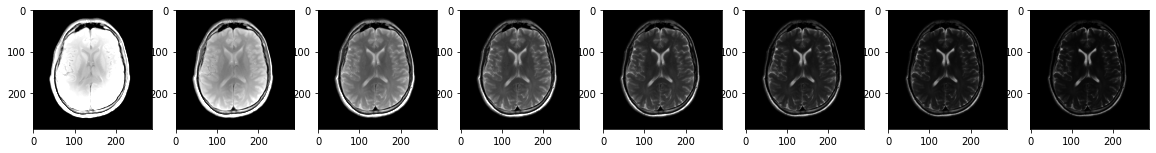

Brain images as acquired on different echoes


In [3]:
for index in range(8):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, 8, index+1)
    plt.imshow(np.abs(brain_images[:,:,2*index]),cmap=plt.get_cmap('gray'),vmin=0,vmax = .0005)
plt.show()
print('Brain images as acquired on different echoes')

In [4]:
t1_min = 100
t1_max = 6000
t2_min = 10
t2_max = 1000
N_t1 = 300
N_t2 = 550

#number of parrallel processes to run, depends upon the number of CPU that we have
import multiprocessing
print("Number of cpu : ", multiprocessing.cpu_count())
par_jobs = multiprocessing.cpu_count()


t1_vals = np.round(np.linspace(t1_min, t1_max, N_t1))
t2_vals = np.round(np.linspace(t2_min, t2_max, N_t2))

print('T1 step:', t1_vals[1] - t1_vals[0], 'ms')
print('T2 step:', t2_vals[1] - t2_vals[0], 'ms')

_t1_vals, _t2_vals = np.meshgrid(t1_vals, t2_vals)
_t1_t2_vals = np.stack((_t1_vals.ravel(), _t2_vals.ravel()), axis=1)
_idxs = _t1_t2_vals[:,0] >= _t1_t2_vals[:,1]
t1_t2_vals = _t1_t2_vals[_idxs,:]
print(t1_t2_vals.shape)

Number of cpu :  32
T1 step: 20.0 ms
T2 step: 2.0 ms
(153356, 2)


In [5]:
import sys#this helps with reading data from multiple places
sys.path.insert(0, './mri-sim-py/epg/')#need to add these paths in the server folder
sys.path.insert(0, 'bart/python')#do we need bart here right now
sys.path.insert(0, './mri-sim-py/t1t2shuffle/')#the main function

import t1t2shuffle as t2sh
import epg

def myfun(t1t2):
    sig_dict = {
        'T1': t1t2[0],
        'T2': t1t2[1],
    }
    TR_vals = np.array([2800])
    TRs = TR_vals
    N_TRs = 3#number of reptitions to get the T1 weighting
    TE = 9.1*2
    ETL = 16
    angles_rad = np.ones((ETL))*180*np.pi/180
    #update the code for stopping the driven equil case
    signal = t2sh.t1t2shuffle2(angles_rad, TE, TRs, 1, T1= sig_dict['T1'], T2 = sig_dict['T2'], driven_equil = False, fr_sign = False)
    return signal/np.linalg.norm(signal)

In [7]:
from multiprocessing import Pool
with Pool(par_jobs) as p:
    result_dict = list((tqdm(p.imap(myfun, t1_t2_vals), total=len(t1_t2_vals), leave=True)))

100%|██████████| 153356/153356 [00:22<00:00, 6797.71it/s]


In [8]:
def dictionary_match(y_sig, Dict, t1t2_list):
    
    # get best match
    z = np.dot(Dict, y_sig)
    #z = np.dot(Dict, y_sig/np.max(y_sig))
    i = np.argmax(np.abs(z))
    
    # get scaling
    # sc = z[i] / sc_list[i]
    
    return z[i], t1t2_list[i,:], i#, sc

In [11]:
def _dictionary_match(y):
    return dictionary_match(y, result_dict, t1_t2_vals)

with Pool(par_jobs) as p:
    result_map = list((tqdm(p.imap(_dictionary_match, (nonzero_data)), total=len(nonzero_data), leave=True,desc="Doing dictionary matching")))


Doing dictionary matching: 100%|██████████| 35818/35818 [11:41<00:00, 51.05it/s]


In [12]:
# reading the output of dictionary match
X_map = np.array(result_map).T
T1_T2_index = X_map[2,:].astype(int)
#print(T1_T2_index)
#print(t1_t2_vals[T1_T2_index,:])

In [17]:
T1_values = t1_t2_vals[T1_T2_index,0]
T2_values = t1_t2_vals[T1_T2_index,1]
PD_values= X_map[0,:]

In [18]:
Im_synthetic1 = np.zeros([288,288])
Im_synthetic1[np.nonzero(image_mask)]  = t1_t2_vals[T1_T2_index,0]

Im_synthetic2 = np.zeros([288,288])
Im_synthetic2[np.nonzero(image_mask)]  = t1_t2_vals[T1_T2_index,1]

Im_synthetic3 = np.zeros([288,288],dtype=complex)
Im_synthetic3[np.nonzero(image_mask)]  = PD_values

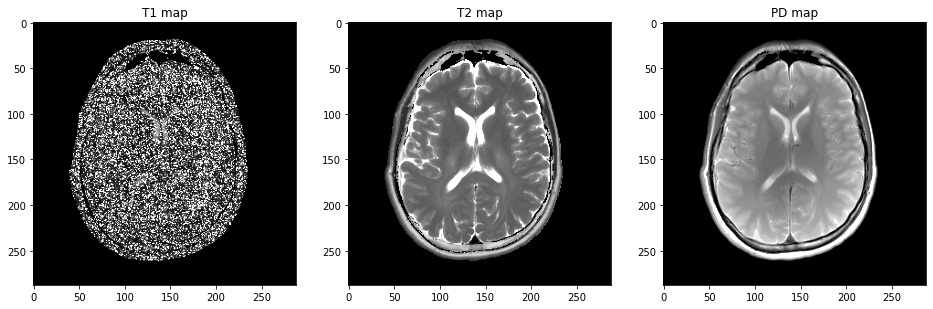

In [19]:
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(Im_synthetic1, cmap='gray',vmax = 2000,vmin=0)
plt.title('T1 map')

plt.subplot(1,3,2)
plt.imshow(Im_synthetic2, cmap='gray',vmax = 200,vmin=10)
plt.title('T2 map')

plt.subplot(1,3,3)
plt.imshow(np.abs(Im_synthetic3), cmap='gray',vmax = .0015,vmin=0)
plt.title('PD map')

plt.show()